<a href="https://colab.research.google.com/github/kerimoglutolga/AdversarialLearning/blob/master/latent_space_fgsm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch

fatal: destination path 'stylegan2-ada-pytorch' already exists and is not an empty directory.


In [2]:
cd stylegan2-ada-pytorch

/content/stylegan2-ada-pytorch


In [3]:
!python legacy.py \
    --source=https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/cifar10.pkl\
    --dest=cifar10.pkl

Loading "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/cifar10.pkl"...
Saving "cifar10.pkl"...
Done.


In [4]:
from legacy import load_network_pkl
import dnnlib
import torch
import numpy as np
import PIL.Image
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.datasets import MNIST
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np 
import torchvision

In [30]:
f = open("cifar10.pkl", "rb")

In [31]:
G = load_network_pkl(f)['G_ema']

In [32]:
cd ..

/content


In [8]:
!git clone https://github.com/huyvnphan/PyTorch_CIFAR10

fatal: destination path 'PyTorch_CIFAR10' already exists and is not an empty directory.


In [9]:
cd PyTorch_CIFAR10

/content/PyTorch_CIFAR10


In [ ]:
cd cifar10_models

In [10]:
!gdown https://drive.google.com/u/0/uc?id=17fmN8eQdLpq2jIMQ_X0IXDPXfI9oVWgq

Downloading...
From: https://drive.google.com/u/0/uc?id=17fmN8eQdLpq2jIMQ_X0IXDPXfI9oVWgq
To: /content/PyTorch_CIFAR10/state_dicts.zip
100% 979M/979M [00:04<00:00, 242MB/s]


In [11]:
!unzip state_dicts.zip 

Archive:  state_dicts.zip
   creating: state_dicts/
  inflating: state_dicts/googlenet.pt  
  inflating: state_dicts/vgg11_bn.pt  
  inflating: state_dicts/vgg13_bn.pt  
  inflating: state_dicts/resnet18.pt  
  inflating: state_dicts/vgg19_bn.pt  
  inflating: state_dicts/vgg16_bn.pt  
  inflating: state_dicts/mobilenet_v2.pt  
  inflating: state_dicts/inception_v3.pt  
  inflating: state_dicts/densenet121.pt  
  inflating: state_dicts/resnet34.pt  
  inflating: state_dicts/densenet161.pt  
  inflating: state_dicts/densenet169.pt  
  inflating: state_dicts/resnet50.pt  


In [54]:
from cifar10_models.mobilenetv2 import mobilenet_v2
my_model = mobilenet_v2(pretrained=True).cpu()

In [55]:
classifier = my_model
_ = classifier.eval()

In [18]:
batch_size = 64
transform = transforms.Compose(
    [transforms.ToTensor(),])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [34]:
import functools
import matplotlib.pyplot as plt
G.synthesis.forward = functools.partial(G.synthesis.forward, force_fp32=True)

In [106]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad

    # Adding clipping to maintain [0,1] range
    # Return the perturbed image
    return perturbed_image

In [146]:
def label_maker(class_idx):
  label = torch.zeros([1, G.c_dim])
  if G.c_dim != 0:
    label[:, class_idx] = 1
  return label

[[0.01114473 0.00419384 0.9305683  0.00863308 0.01593325 0.00658916
  0.00772051 0.00573066 0.0050765  0.00440992]] [[0.9753422  0.00236722 0.00419011 0.00262256 0.00227615 0.00198099
  0.00208477 0.00219238 0.00407463 0.00286897]]
[2] [0]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


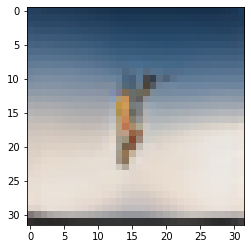

In [186]:
class_idx = 0
label = torch.zeros([1, G.c_dim])
loss_fn = nn.CrossEntropyLoss()
if G.c_dim != 0:
  label[:, class_idx] = 1
G.zero_grad()
z = torch.randn((1,512))
z.requires_grad = True
w = G.mapping(z=z,c=label)
img = G.synthesis(w, noise_mode="random")
loss = loss_fn(classifier(img), label)
w.retain_grad()
loss.backward()
w_grad = w.grad.data
perturbed_w = fgsm_attack(w, 0.05, w_grad)
perturbed_img = G.synthesis(perturbed_w, noise_mode="random")
print(nn.functional.softmax(classifier(img)).data.numpy(), nn.functional.softmax(classifier(perturbed_img)).data.numpy())
print(torch.argmax(classifier(img), dim=1).data.numpy(), torch.argmax(classifier(perturbed_img), dim=1).data.numpy())
img_print = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
perturbed_img_print = (perturbed_img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)

plt.imshow(img_print[0])

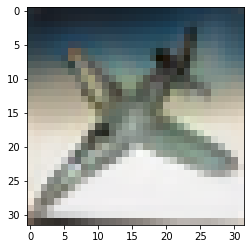

In [187]:
plt.imshow(perturbed_img_print[0])

In [ ]:
""""
label = torch.zeros([500, G.c_dim])
noise_mode = "random"
truncation_psi = 1
class_idx = 0
if G.c_dim != 0:
  label[:, class_idx] = 1
print(label.shape)
with torch.no_grad():
  z = torch.from_numpy(np.random.randn(500, G.z_dim))
  img = (G(z, label, truncation_psi=truncation_psi, noise_mode=noise_mode, force_fp32=True) + 1) * 0.5

labels = label
imgs = img

for class_idx in range(1,10):
  label = torch.zeros([500, G.c_dim])
  noise_mode = "random"
  truncation_psi = 1
  #class_idx = 7
  if G.c_dim != 0:
    label[:, class_idx] = 1
  print(label.shape)
  with torch.no_grad():
    z = torch.from_numpy(np.random.randn(500, G.z_dim))
    img = (G(z, label, truncation_psi=truncation_psi, noise_mode=noise_mode, force_fp32=True) + 1) * 0.5
    labels = torch.vstack((labels, label))
    imgs = torch.vstack((imgs, img)) 


  img_new = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8).cpu().numpy()
"""


In [ ]:
for i,(x,y) in enumerate(train_loader2):
  image = x
  img_new = (image.permute(0, 2, 3, 1)*255).to(torch.uint8).cpu().numpy()
  plt.imshow(img_new[0])
  print(y)
  print(torch.argmax(classifier(image.cuda()),dim=1))
  if i>0:break

In [ ]:
label = torch.zeros([10, G.c_dim])
noise_mode = "random"
truncation_psi = 1
class_idx = 4
if G.c_dim != 0:
  label[:, class_idx] = 1
print(label.shape)
with torch.no_grad():
  z = torch.from_numpy(np.random.randn(10, G.z_dim))
  img = G(z, label, truncation_psi=truncation_psi, noise_mode=noise_mode, force_fp32=True)
img_new = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8).cpu().numpy()
plt.imshow(img_new[0])
torch.argmax(nn.functional.softmax(classifier((img.cuda()+1)/2), dim=1), dim=1)

In [ ]:
labels.shape

In [ ]:
def accuracy(net):
  correct = 0
  total = 0
  with torch.no_grad():
      for x,y in test_loader:
          images, labels = x.cuda()*2-1, y.cuda()

          outputs = net((images))
          predicted = torch.argmax(outputs.data, 1)

          total += labels.size(0)
          correct += (predicted == labels).sum().item()
  print('Accuracy: %s %%' % (100 * correct / total))

accuracy(classifier)

In [ ]:
class cifargen(Dataset):
    """Face Landmarks dataset."""

    def __init__(self):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.imgs = imgs
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()


        return self.imgs[idx], self.labels[idx]

In [ ]:
dataset = cifargen()
loader = torch.utils.data.DataLoader(dataset, batch_size=64,
                                         shuffle=True, num_workers=2)

In [ ]:
import torch.utils.data as data_utils

train2 = data_utils.TensorDataset(imgs, torch.argmax(labels,dim=1).squeeze(0))
train_loader2 = data_utils.DataLoader(train2, batch_size=64, shuffle=True)


In [ ]:
cd ..


In [ ]:
!python train.py --download_weights 1

In [ ]:
torch.nn.functional.softmax(classifier(imgs[0].unsqueeze(0).cuda()))

In [ ]:
torch.nn.functional.softmax(classifier(imgs[0:64].cuda()))

In [ ]:
"""label = torch.zeros([10, G.c_dim])
noise_mode = "random"
truncation_psi = 1
class_idx = 7
if G.c_dim != 0:
  label[:, class_idx] = 1
print(label.shape)
   


z = torch.from_numpy(np.random.randn(10, G.z_dim))
img = G(z, label, truncation_psi=truncation_psi, noise_mode=noise_mode, force_fp32=True) 
img_new = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8).cpu().numpy()
plt.imshow(img_new[2])
print(label)

print(one_hot)"""

epochs = 10
lr = 1e-4
optimizer = torch.optim.Adam(classifier.parameters(), lr=lr)
CELoss = nn.CrossEntropyLoss()

print
for epoch in range(epochs):
  for i, (x,y) in enumerate(loader):
    x,y = x.cuda(), y.cuda()
    print(x.shape)
    print(y.shape)
    break
    optimizer.zero_grad()
    fool_loss = CELoss(classifier(x), torch.argmax(y, dim=1))
    loss = fool_loss 
    loss.backward()
  
    optimizer.step()
    if i%100==0:
      print('Epoch [{}/{}], Step [{}/{}], Loss: {}'.format(epoch+1, epochs, i+1, len(train_loader), loss.item()))